**building ID and probability to Christina**

Only consider first arrival time

Arrival time: calc vs actual

# File Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
pd.options.mode.chained_assignment = None
import datetime
from matplotlib.lines import Line2D
from IPython import embed
import folium
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
import pickle

# Load data

In [2]:
# Load data already merged with fenz data
df_merge_with_fenz = pd.read_csv('shannon_data_nonres.csv')
df_merge_with_fenz.columns = [x.strip('.x') for x in list(df_merge_with_fenz)]
# only consider callouts which happen on about the same timeframe as is given in the all nz building callout time calculation
df_merge_with_fenz = df_merge_with_fenz[df_merge_with_fenz['First_Arrival_Mins']<30]

# load all of nz building data with sa1 codes already attached
df_new_zealand = pd.read_csv('buildings_complete_dataset.csv') # Buildings_AllNZ_AllColumns_SA1

# Correct added column names to match the merge with fenz data
df_new_zealand = df_new_zealand.rename(columns={'NEAR_DIST':'GNS_Neighb_Dist','travel_time_secs':'First_Arrival_Mins'})
df_new_zealand.drop('OBJECTID',axis=1,inplace=True)
df_new_zealand['First_Arrival_Mins'] = df_new_zealand['First_Arrival_Mins']/60
df_oid = df_new_zealand[['Outline_id','x_coord','y_coord']].set_index(['Outline_id'])

# load census data
df_dwelling1 = pd.read_csv('Census/census_dwelling1.csv')
df_dwelling2 = pd.read_csv('Census/census_dwelling2.csv')
df_dwelling1.rename(columns={'SA1':'sa1'},inplace=True)
df_dwelling2.rename(columns={'SA1':'sa1'},inplace=True)

df_household = pd.read_csv('Census/census_household.csv')
df_individual1 = pd.read_csv('Census/census_individual_1.csv')
df_individual2a = pd.read_csv('Census/census_individual_2a.csv')
df_individual2b = pd.read_csv('Census/census_individual_2b.csv')
df_individual2c = pd.read_csv('Census/census_individual_2c.csv')
df_individual3a = pd.read_csv('Census/census_individual_3a.csv')
df_individual3b = pd.read_csv('Census/census_individual_3b.csv')

df_list = [df_dwelling1, df_dwelling2, df_household, df_individual1, df_individual2a,
           df_individual2b, df_individual2c, df_individual3a, df_individual3b]

del df_dwelling1
del df_dwelling2
del df_household
del df_individual1
del df_individual2a
del df_individual2b
del df_individual2c
del df_individual3a
del df_individual3b

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Preproessing of census and all NZ building data 

Data needs to be in the same form as the data already joined to FENZ data for the model pipeline

In [3]:
def merge_dataframes_on_index(list_of_census_dfs):
    """
    Merge a list of pandas DataFrames by joining on their index.
    
    Parameters:
    df_list (list of pandas DataFrames): List of pandas DataFrames to be merged.
    
    Returns:
    merged_df (pandas DataFrame): Merged DataFrame.
    """
    list_of_census_dfs = [x[~x.sa1.isna()] for x in list_of_census_dfs]
    list_of_census_dfs = [x.set_index('sa1') for x in list_of_census_dfs]
    
    if not list_of_census_dfs:
        return None
    
    # Check if all DataFrames have unique indices
    indices = [df.index.is_unique for df in list_of_census_dfs]
    if not all(indices):
        raise ValueError("All DataFrames must have unique indices.")
    
    # Merge DataFrames
    merged_df = pd.concat(list_of_census_dfs, axis=1)
    
    return(merged_df)

In [4]:
def merging_and_cleaning_datasets(list_of_census_dfs,df_gns):
    df_gns_cp = df_gns.copy()
    
    df_census_data = merge_dataframes_on_index(list_of_census_dfs)
    
    df_census_data.index.names = ['SA12018_V1']
    df_gns_cp.set_index('sa1Codes',inplace=True)
    df_gns_cp.index.names = ['SA12018_V1']
    
    df_gns_cp.rename(columns={
        'Outline_id':'OID_',
        "Use_Category":"GNS_Use_Category",
        "Construction_Type":"GNS_Construction_Type_1",
        "Age":"GNS_Age",
        "Storeys":"GNS_Storeys",
        "Floor_Area":"GNS_Floor_Area",
        "Site_Cover":"GNS_Site_Cover",
        "Roof_Const":"GNS_Roof_Const",
        "Wall_Const":"GNS_Wall_Const",
        "Floor_Height":"GNS_Floor_Hgt",
        "Roof_Pitch":"GNS_Roof_Pitch",
        "Parapet":"GNS_Parapet",
        "Rep_Cost":"GNS_Rep_Cost",
        "Rep_Cost_multi":"GNS_Rep_Cost_multi",
        "Units":"GNS_Num_Units",
        "Res_Units":"GNS_Res_Units",
        "NonRes_Units":"GNS_NonRes_Units",
        "Assign_type":"GNS_Assign_type",
        "Building_dist":"GNS_Building_dist",
        "Neighbour_dist":"GNS_Neighb_Dist"
    },inplace=True)
    df_gns_cp = df_gns_cp.drop(['Point_id','Point_id','x_coord','y_coord','UseCat_code','ConType_code','Roof_code','Wall_code','RoofPitch_code','Parapet_code','Assign_code'],axis=1)
    df_joined = df_gns_cp.join(df_census_data)
    
    df_joined = df_joined.reset_index()
    
    return(df_joined)


In [5]:
df_joined = merging_and_cleaning_datasets(df_list,df_new_zealand)

# remove all columns which are not in the combined fenz data (there are some gns variables which get dropped here?)
df_joined = df_joined[[x for x in list(df_joined) if x in list(df_merge_with_fenz)]]
del df_new_zealand
del df_list

In [6]:
np.mean(df_merge_with_fenz['First_Arrival_Mins'])

7.736117072892322

In [7]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.25)

4.93

In [8]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.75)

9.07

In [9]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.9999)

29.85992599999998

In [10]:
np.mean(df_joined['First_Arrival_Mins'])/60

0.07452266206062506

In [11]:
(df_joined['First_Arrival_Mins']).quantile(0.25)

2.446958817358365

In [12]:
(df_joined['First_Arrival_Mins']).quantile(0.9999)

30.0

In [13]:
(df_joined['First_Arrival_Mins']).quantile(0.999)

29.254817602681037

(array([20453.,  8416.,  1115.,   289.,   111.,    47.,    22.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <BarContainer object of 19 artists>)

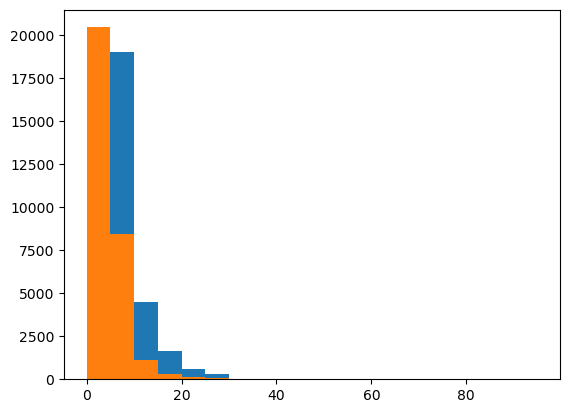

In [14]:
plt.hist(df_merge_with_fenz['First_Arrival_Mins'],bins=np.arange(0,100,5))

plt.hist((df_joined['First_Arrival_Mins']).sample(len(df_merge_with_fenz)),bins=np.arange(0,100,5))

# Setup Model Pipeline

In [15]:
def combine_cols(df,label):
    cols = [x for x in df if label in x]
    most_likely = df[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [x.replace('P','') for x in most_likely]
    most_likely = [x.replace('plus','') for x in most_likely]
    most_likely = [float(x) for x in most_likely]
    df[f'most_likely_{label}'] = most_likely
    df.drop(cols,axis=1,inplace=True)
    return(df)

In [16]:
def processing_data(df_processed_data):
    
    # removing minutes for now because no way to use in risk rating
    if 'Date_Time' in list(df_processed_data):
        df_processed_data['date'] = [x.split(' ')[0] for x in df_processed_data['Date_Time']]
        df_processed_data['date_count'] = [(datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0]))-datetime.datetime(2003,1,1)).days for x in df_processed_data.date]
        # df_processed_data['minutes'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_processed_data['time']]
        # df_processed_data['time'] = [x.split(' ')[1] for x in df_processed_data['Date_Time']]
        df_processed_data.drop(['Date_Time','date'],axis=1,inplace=True)
    else: # this is the all of nz data case, where there is no date from fenz
        df_processed_data['date_count'] = (datetime.datetime.today()-datetime.datetime(2003,1,1)).days
    
    
    # Split categorical and numeric variables
    numeric_vars = [x for x in list(df_processed_data) if type(df_processed_data.loc[0,x])!=type('str')]
    categorical_vars = [x for x in list(df_processed_data) if (type(df_processed_data.loc[0,x])==type('str'))&('Date_Time' not in x)]
    
    # convert categorical variables to one-hot-encoded variables (binary)
    df_one_hot_encoded = pd.get_dummies(df_processed_data[categorical_vars])

    # get just numeric variables
    df_numeric = df_processed_data[numeric_vars]
    df_numeric = df_numeric.astype(float)

    # Add back the one-hot-encoded categorical variables
    df_numeric = df_numeric.join(df_one_hot_encoded)

    # First, remove columns which have a significant portion of NAs (we're saying more than 1000
    na_count = df_numeric.isna().sum().sort_values(ascending=True)
    
    # we're going to filter out nans for the analysis. OID and arrival has lots of nans. Will exclude OID from independent variables list, but want to keep it in the data frame so that we have a way of matching the coordiantes back in. We want arrival time because of it's predictive capability
    arrival = df_numeric['First_Arrival_Mins']
    OID = df_numeric['OID_']
    df_numeric = df_numeric[[x for x in list(df_numeric) if (x not in list(na_count[na_count>11000].index))&((x!='OID_')|(x!='First_Arrival_mins'))]]
    df_numeric['OID_'] = OID # put oid back
    if 'First_Arrival_Mins' not in list(df_numeric):
        df_numeric['First_Arrival_Mins'] = arrival # put arrival back
    
    # Now for all the remaining nans, remove the rows
    df_numeric = df_numeric.dropna()

    # combine some variabels to reduce the number of features
    # df_numeric = combine_cols(df_numeric,'Rooms.')
    # df_numeric = combine_cols(df_numeric,'Beds.')    
    # # df_numeric = combine_cols(df_numeric,'noVehc.') # too many nans
    # df_numeric = combine_cols(df_numeric,'children.')

    # label = 'yrs_at_res.'
    # df_numeric.rename(columns={'yrs_at_res.30more':'yrs_at_res.30'},inplace=True) 
    # cols = [x for x in df_numeric if label in x]
    # most_likely = df_numeric[cols].idxmax(axis=1)
    # most_likely = [x.strip(label) for x in most_likely]
    # most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
    # df_numeric[f'most_likely_{label}'] = most_likely
    # df_numeric.drop(cols,axis=1,inplace=True)

#     label = 'income.'
#     df_numeric.rename(columns={'income.less5K':'income.5K',},inplace=True) 
#     cols = [x for x in df_numeric if (label in x)&('K' in x)]
#     most_likely = df_numeric[cols].idxmax(axis=1)
#     most_likely = [x.strip(label) for x in most_likely]
#     most_likely = [x.replace('K','').replace('P','') for x in most_likely]
#     most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
#     df_numeric[f'most_likely_{label}'] = most_likely
#     df_numeric.drop(cols,axis=1,inplace=True)

#     label = 'hrsEmploy.'
#     df_numeric.rename(columns={'hrsEmploy.60more':'hrsEmploy.60'},inplace=True) 
#     cols = [x for x in df_numeric if (label in x)]
#     most_likely = df_numeric[cols].idxmax(axis=1)
#     most_likely = [x.strip(label) for x in most_likely]
#     most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
#     df_numeric[f'most_likely_{label}'] = most_likely
#     df_numeric.drop(cols,axis=1,inplace=True)

#     df_numeric['earning_not_from_work'] = df_numeric['income.ACC']+df_numeric['income.supported']+df_numeric['income.jobSeeker']+df_numeric['income.soleParent']+df_numeric['income.otherBen']
#     df_numeric['combined_not_working'] = df_numeric['employed.notInLF']+df_numeric['employed.Unemployed']
#     df_numeric['earning_from_work'] = df_numeric['income.salary']+df_numeric['income.selfEmp']
#     df_numeric['studying'] = df_numeric['study.fullTime']+df_numeric['study.partTime']
#     df_numeric['diffCom.atleastSome'] = df_numeric['diffCom.some']+df_numeric['diffCom.aLot']+df_numeric['diffCom.cannot']
#     df_numeric['diffWalk.atleastSome'] = df_numeric['diffWalk.some']+df_numeric['diffWalk.aLot']+df_numeric['diffWalk.cannot']
#     df_numeric['homeOwn.OwnOrTrust'] = df_numeric['homeOwn.trust']+df_numeric['homeOwn.own']

    # cols = [x for x in list(df_numeric) if 'damp' in x]
    # numeric_damp = []
    # for row in df_numeric[cols].idxmax(axis=1):
    #     if row=='damp.no':
    #         numeric_damp.append(0)
    #     elif row=='damp.sometimes':
    #         numeric_damp.append(1)
    #     elif row=='damp.always':
    #         numeric_damp.append(2)
    #     else:
    #         asdf
    # df_numeric['dampness'] = numeric_damp

    # removing columns we don't want to model as per discussion with Christina
    heat_source_cols = [x for x in df_numeric if "Heat_Source" in x]
    fire_source_cols = [x for x in df_numeric if "Fire_Cause" in x]
    mould_cols = [x for x in df_numeric if 'mould' in x]
    fuel_cols = [x for x in df_numeric if 'fuel' in x]
    smoking_cols = [x for x in df_numeric if ('smoking' in x)&('regular' not in x)]
    dwelling_cols = [x for x in df_numeric if 'dwelling' in x]
    prev_residence_cols = [x for x in list(df_numeric) if ('res_5yrs_prev' in x)&('same' not in x)]
    employed_cols = [x for x in list(df_numeric) if ('employed' in x)]
    income_cols =  ['income.ACC','income.supported','income.jobSeeker','income.soleParent','income.otherBen','income.salary','income.selfEmp']
    damp_cols =  ['damp.no','damp.sometimes','damp.always']
    gns_use = [x for x in list(df_numeric) if 'GNS_Use_Category' in x]
    temp_remove = ['Percent_Not_Saved','Damage_m2']
    comp_of_casualties = ['Injury_Count','Fatality_Count']
    always_zero_variables = ['GNS_Use_Category_Appurtenant','GNS_Use_Category_Forestry, Mining','GNS_Roof_Const_Roughcast,etc']
    others_to_remove = ['MB2020_V2_','SA12018_V1','occupied','ResAway','nonPartnered','born.overseas','study.fullTime','study.partTime',
                         'HSCert','HSDip','homeOwn.trust','homeOwn.own','diffCom.some','diffCom.aLot','diffCom.cannot','diffWalk.some','diffWalk.aLot','diffWalk.cannot',
                        'age.30_64','age.15_29'] # removed OID_ from here

    removal_list = heat_source_cols+fire_source_cols+mould_cols+fuel_cols+smoking_cols+dwelling_cols+prev_residence_cols+employed_cols+income_cols+others_to_remove+damp_cols+gns_use+temp_remove+comp_of_casualties+always_zero_variables

    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in removal_list]]
    
    ###################
    # ADDITIONAL DELETES 
    ###################
    # too_many_nan_delete = [x for x in df_numeric if 'noVehc.' in x]
    # df_numeric.drop(too_many_nan_delete,axis=1,inplace=True)
    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['Second_Arrival_Mins']]] #'GNS_Neighb_Dist','First_Arrival_Mins', 
    add_delete = ['NZDep2018', 'yearsInNZ.20years', 'occupation.manager', 'occupation.profess', 'occupation.trade', 'occupation.community', 'occupation.clerical', 'occupation.sales', 'occupation.machinery', 'occupation.labourer', 'landlord.private', 'rent.median', 'tele.no', 'tele.land']
    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in add_delete]]
    
    return(df_numeric)
    


In [17]:
def test_train_split(df_unsplit,target_variable):
    # binarise the target variable for classification algo
    df_unsplit.loc[:,target_variable] = [0 if x<1 else 1 for x in df_unsplit[target_variable]]
    
    independent_variables = [x for x in list(df_unsplit) if x!=target_variable]
    independent_variables.remove('OID_')
    
    print(df_unsplit.date_count)

    # split into testing and training
    df_training = df_unsplit.sample(int(len(df_unsplit)*0.8))
    df_testing = df_unsplit[~df_unsplit.index.isin(df_training.index)]

    # Normalise the data
    training_mins = np.min(df_training[independent_variables])
    training_maxes = np.max(df_training[independent_variables])
    
    print(df_training.date_count)
    print(training_mins.date_count)
    print(training_maxes.date_count)

    df_training.loc[:,independent_variables] = (df_training[independent_variables]-training_mins)/(training_maxes-training_mins)
    df_testing.loc[:,independent_variables] = (df_testing[independent_variables]-training_mins)/(training_maxes-training_mins)
    
    print(df_testing.date_count)

    # Adding extra rows which have casualties so that the dataset is approximately equal
    df_training_0 = df_training[df_training[target_variable]==0]
    df_training_gt0 = df_training[df_training[target_variable]>0]
    df_training = df_training_0.append(pd.concat([df_training_gt0]*int(1+len(df_training_0)/len(df_training_gt0))))

    return(df_training,df_testing,independent_variables)

In [18]:
# Train the model
def model_test(mod,df_training,df_testing,independent_variables,target_variable,modname):
    not_for_prediction_list = ['First_Arrival_Mins','Second_Arrival_Mins','date_count','minutes']
    prediction_list = [x for x in independent_variables if x not in not_for_prediction_list]
    
    mod.fit(df_training[independent_variables],df_training[target_variable])
    
    pickle.dump(mod, open(modname, 'wb'))

    predictions = mod.predict(df_testing[independent_variables])
    predictions_proba = mod.predict_proba(df_testing[independent_variables])
    
    df_testing.loc[:,f'{target_variable}_predicted'] = predictions
    df_testing.loc[:,'error'] = df_testing[target_variable]-df_testing[f'{target_variable}_predicted']

    df_testing.loc[:,f'{target_variable}_Probability'] = predictions_proba[:,1] 
    
    actual_vs_predicted_casuality_dict = {}
    for casualty_count,group in df_testing.groupby(target_variable):
        actual_vs_predicted_casuality_dict.update({
            casualty_count:{k:len(v) for k,v in group.groupby(f'{target_variable}_predicted')}
        })

    df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
    
    tp = df_result_summary.loc[1,1]
    tn = df_result_summary.loc[0,0]
    fn = df_result_summary.loc[1,0]
    fp = df_result_summary.loc[0,1]

    fscore = 2*tp/(2*tp+fp+fn)

    print('F-score',fscore)
    print('')
    
    print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
    return(df_result_summary,mod)

# Run Model Pipeline on FENZ data

In [19]:
# lst = df_training.T.dropna().T
# [x for x in list(df_training) if x not in lst]

In [20]:
    # if 'Date_Time' in list(df_processed_data):
    #     df_processed_data['date'] = [x.split(' ')[0] for x in df_processed_data['Date_Time']]
    #     df_processed_data['date_count'] = [(datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0]))-datetime.datetime(2003,1,1)).days for x in df_processed_data.date]
    #     # df_processed_data['minutes'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_processed_data['time']]
    #     # df_processed_data['time'] = [x.split(' ')[1] for x in df_processed_data['Date_Time']]
    #     df_processed_data.drop(['Date_Time','date'],axis=1,inplace=True)
    # else: # this is the all of nz data case, where there is no date from fenz
    #     df_processed_data['date_count'] = (datetime.datetime.today()-datetime.datetime(2003,1,1)).days

In [21]:
# np.unique(df_processed_data.date_count)

In [22]:
# df_processed_data = df_merge_with_fenz.copy()
# df_processed_data['date'] = [x.split(' ')[0] for x in df_processed_data['Date_Time']]
# df_processed_data['date_count'] = [(datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0]))-datetime.datetime(2003,1,1)).days for x in df_processed_data.date]
# # df_processed_data['minutes'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_processed_data['time']]
# # df_processed_data['time'] = [x.split(' ')[1] for x in df_processed_data['Date_Time']]
# df_processed_data.drop(['Date_Time','date'],axis=1,inplace=True)
# # else: # this is the all of nz data case, where there is no date from fenz
# #     df_processed_data['date_count'] = (datetime.datetime.today()-datetime.datetime(2003,1,1)).days

In [23]:

# df_unsplit = df_processed_data.copy()

# df_training = df_unsplit.sample(int(len(df_unsplit)*0.8))
# df_testing = df_unsplit[~df_unsplit.index.isin(df_training.index)]

# minn = np.min(df_unsplit['date_count'])
# maxx = np.max(df_unsplit['date_count'])

# df_training.loc[:,'date_count'] = (df_training['date_count']-minn)/(maxx-minn)
# df_testing.loc[:,'date_count'] = (df_testing['date_count']-minn)/(maxx-minn)


In [24]:
target_variable = 'Casualty_Count'

df_numeric = processing_data(df_merge_with_fenz)
# del df_merge_with_fenz
df_training,df_testing,independent_variables = test_train_split(df_numeric,target_variable)

del df_numeric
df_result_summary,mod = model_test(GradientBoostingClassifier(),df_training,df_testing,independent_variables,target_variable,'casualty_mod.sav')
df_result_summary

0        7304.0
1        7304.0
2        7304.0
3        7303.0
4        7303.0
          ...  
35454       1.0
35455       1.0
35458       0.0
35461       0.0
35462       0.0
Name: date_count, Length: 23973, dtype: float64
26780    1507.0
5216     6045.0
7443     5573.0
10604    4878.0
18909    2969.0
          ...  
34896      95.0
26267    1598.0
30596     845.0
8122     5440.0
32647     473.0
Name: date_count, Length: 19178, dtype: float64
0.0
7304.0
0        1.000000
2        1.000000
4        0.999863
14       0.999589
15       0.999589
           ...   
35430    0.000821
35436    0.000685
35446    0.000411
35448    0.000411
35453    0.000274
Name: date_count, Length: 4795, dtype: float64
F-score 0.037296037296037296

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


,0,1
0,3532,1187
1,52,24


# Analyse Results

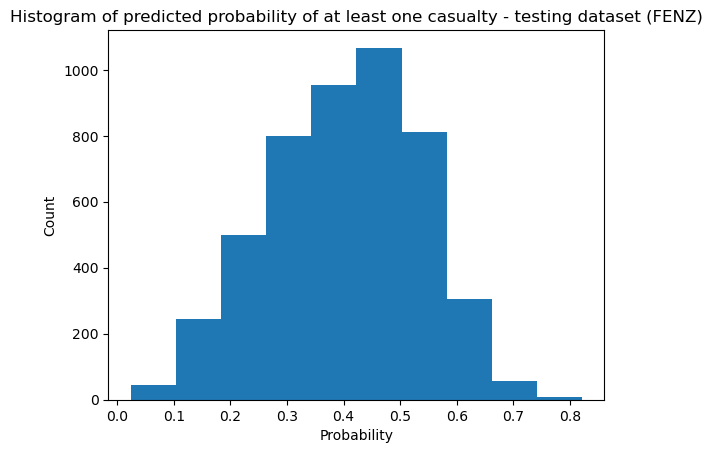

In [25]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_testing[target_variable+"_Probability"])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - testing dataset (FENZ)')

plt.show()

In [26]:
# Split risk categories equally
qb12 = df_testing[target_variable+'_Probability'].quantile(0.3333)
qb23 = df_testing[target_variable+'_Probability'].quantile(0.6667)

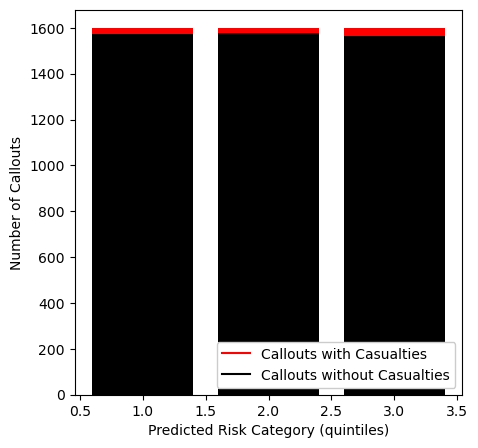

In [27]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((1,1),(0,0))

for q,qlb,qub in zip(np.arange(1,4,1),[0,qb12,qb23],[qb12,qb23,1]):
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]),color='k')
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==1)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]),color='r',
            bottom=len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]))
    
ax1.set_ylabel('Number of Callouts')
ax1.set_xlabel('Predicted Risk Category (quintiles)')
# ax1.set_ylim([0,2250])

casualties = Line2D([],[],c='r')
no_casualties = Line2D([],[],c='k')

legend = plt.legend([casualties,no_casualties],['Callouts with Casualties','Callouts without Casualties'],loc='lower right')
legend.get_frame().set_alpha(None)

In [28]:
df_testing['risk_categories'] = pd.cut(df_testing[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=np.arange(1,4,1))

In [29]:
df_testing[['Casualty_Count','Casualty_Count_Probability','risk_categories']]

,Casualty_Count,Casualty_Count_Probability,risk_categories
0,0,0.345829,2
2,0,0.291451,1
4,0,0.586581,3
14,0,0.175426,1
15,0,0.192262,1
...,...,...,...
35430,0,0.652616,3
35436,0,0.659866,3
35446,0,0.170640,1
35448,0,0.544379,3


# Run Model Pipeline on all Data

In [30]:
df_numeric_2 = processing_data(df_joined)

In [31]:
predictions_proba = mod.predict_proba(df_numeric_2[independent_variables])

In [32]:
df_numeric_2[f'{target_variable}_Probability'] = predictions_proba[:,1]

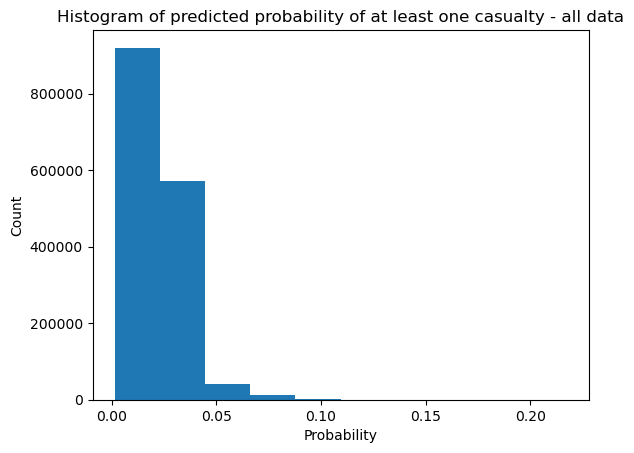

In [33]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_numeric_2[f'{target_variable}_Probability'])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - all data')

plt.show()

In [34]:
np.max(df_numeric_2[f'{target_variable}_Probability'])

0.21698047184109479

In [35]:
df_numeric_2 = df_numeric_2.set_index('OID_')

In [36]:
df_numeric_2 = df_numeric_2.join(df_oid)

In [37]:
df_numeric_2.to_csv('buildings_with_casualty_prob_nonres.csv')

KeyboardInterrupt: 

# Plot spatially

In [ ]:
# Split risk categories equally
qb12 = df_numeric_2[f'{target_variable}_Probability'].quantile(0.3333)#np.max(df_numeric_2['Casualty_Probability'])/3
qb23 = 0.05#np.max(df_numeric_2['Casualty_Probability'])*2/3

df_numeric_2['risk_categories'] = pd.cut(df_numeric_2[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=np.arange(1,4,1))

In [ ]:
plt.scatter(df_numeric_2.x_coord,df_numeric_2.y_coord,c=df_numeric_2.risk_categories)

In [ ]:
df_numeric_2[['x_coord','y_coord']].head(10)

In [ ]:
data = {'x_coord': [174.7633, 175.2810, 175.0112],
        'y_coord': [-36.8485, -37.7870, -37.8056]}
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['x_coord'], data['y_coord']))
gdf

In [ ]:
df_numeric_2_colored = df_numeric_2.copy()
df_numeric_2_colored['risk_categories'] = pd.cut(df_numeric_2_colored[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=['blue','black','red'])

df_numeric_2_sample = df_numeric_2_colored.sample(10000)
geometry = [Point(xy) for xy in zip(df_numeric_2_sample.x_coord, df_numeric_2_sample.y_coord)]
df = df_numeric_2_sample[['risk_categories']].rename(columns={'risk_categories':'color'})
gdf = gpd.GeoDataFrame(df, crs="EPSG:2193", geometry=geometry).to_crs('EPSG:4326')

In [ ]:
c1 = plt.scatter([],[],c='b')
c2 = plt.scatter([],[],c='k')
c3 = plt.scatter([],[],c='r')


leg = plt.legend([c1,c2,c3],['Low','Medium','High'],facecolor ='0.9')
plt.axis('off')

fig = leg.figure
fig.canvas.draw()

bbox = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.savefig('legend.png',bbox_inches=bbox)

In [ ]:
# Assuming gdf is your GeoDataFrame with 'color' column and 'geometry' column containing Point geometries

nz_map = folium.Map(location=[-40.9006, 174.8860], zoom_start=5)

# Create a MarkerCluster layer
marker_cluster = MarkerCluster(disable_clustering_at_zoom=10).add_to(nz_map)

# Add circle markers to the map for each point
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],  # Reversed order for Folium
        radius=5,  # Adjust marker radius for better visibility
        color=row['color'],  # Set marker border color
        fill=True,
        fill_color=row['color'],  # Set marker fill color
        fill_opacity=0.6,  # Adjust opacity for better visibility
    ).add_to(marker_cluster)
    
    
# Legend 
legend_html = """
<div style="position: fixed; bottom: 15px; right: 1400px; z-index: 1000;width: 100px; height: 66px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" style="max-width: 100%; max-height: 100%;">
</div>
""".format("legend.png")

nz_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
nz_map.save('nz_map.html')

# # Display the map
# nz_map


# Feature importance

In [ ]:
df_feature_importance = pd.DataFrame.from_dict({x:y for x,y in zip(list(independent_variables),mod.feature_importances_)},orient='index').sort_values(0,ascending=False)
print('Top 20 feature importance - all add up to 1.00')
df_feature_importance.head(50)

In [ ]:
df_feature_importance.tail(50)

# Model for Building Fire

In [ ]:
# travel time should be removed

In [ ]:
df_was_fire = processing_data(df_merge_with_fenz)
df_was_fire.drop(['Casualty_Count'],axis=1,inplace=True)
df_all_buildings = processing_data(df_joined)

# This may not be the best thing to do, but drop duplicated buildings (maybe there are some with identical characteristics?)
df_all_buildings = df_all_buildings.drop_duplicates()
df_was_fire = df_was_fire.drop_duplicates()

In [ ]:
df_was_fire['was_fire'] = 1
df_all_buildings['was_fire'] = 0

In [ ]:
df_with_and_without_fire = pd.concat([df_all_buildings]+[df_was_fire]*int(1+len(df_all_buildings)/len(df_was_fire)))
df_with_and_without_fire = df_with_and_without_fire.drop(['date_count'],axis=1)
# Not sure why there weren't any duplicates (other than my artificial ones) to drop?

In [ ]:
target_variable = 'was_fire'
df_training_was_fire,df_testing_was_fire,independent_variables_was_fire = test_train_split(df_with_and_without_fire,target_variable)

In [ ]:
mylist = list(df_training_was_fire.T.dropna().T)

In [ ]:
[x for x in list(df_training_was_fire) if x not in mylist]

In [ ]:

df_result_summary_was_fire,mod_was_fire = model_test(GradientBoostingClassifier(),df_training_was_fire,df_with_and_without_fire,independent_variables_was_fire,target_variable,'was_fire.sav')
df_result_summary_was_fire

# Analyse If building fire occurs Results

In [ ]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_testing_was_fire['was_fire_Probability'])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - testing dataset (FENZ)')

plt.show()